# **DESAFIO DE CLASSIFICAÇÃO - NVIDIA**

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Link para o dataset: https://drive.google.com/file/d/1zjK8zQK5zvhR_r2chWI5dCjeOwASlPfb/view

In [2]:
df = pd.read_csv('fraud_detection_dataset.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1,0
4,1,PAYMENT,11668.14000,C2048537720,41554.00000,29885.86000,M1230701703,0.00000,0.00000,0,0


In [4]:
df.shape

(6362620, 11)

## Avaliação e tratamento de dados

In [5]:
# Observando se há valores duplicados

df.duplicated().sum()

0

In [6]:
# Observando se há valores nulos

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [3]:
# Renomeando as colunas

df.rename(columns={'step': 'Passo', 
                    'type': 'Tipo',
                    'amount': 'Quantia',
                    'nameOrig': 'ClienteOrigem',
                    'oldbalanceOrg': 'SaldoInicialOrigem',
                    'newbalanceOrig': 'SaldoFinalOrigem',
                    'nameDest': 'ClienteDestino',
                    'oldbalanceDest': 'SaldoInicialDestino',
                    'newbalanceDest': 'SaldoFinalDestino',
                    'isFraud': 'ÉFraude',
                    'isFlaggedFraud': 'SinalizadaComoFraude'}, inplace = True)

In [4]:
# Renomeando os valores da coluna 'Tipo'

df['Tipo'] = df['Tipo'].str.replace('PAYMENT', 'Pagamento')
df['Tipo'] = df['Tipo'].str.replace('TRANSFER', 'Transferência')
df['Tipo'] = df['Tipo'].str.replace('DEBIT', 'Débito')
df['Tipo'] = df['Tipo'].str.replace('CASH_IN', 'Depósito')
df['Tipo'] = df['Tipo'].str.replace('CASH_OUT', 'Saque')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Passo                 int64  
 1   Tipo                  object 
 2   Quantia               float64
 3   ClienteOrigem         object 
 4   SaldoInicialOrigem    float64
 5   SaldoFinalOrigem      float64
 6   ClienteDestino        object 
 7   SaldoInicialDestino   float64
 8   SaldoFinalDestino     float64
 9   ÉFraude               int64  
 10  SinalizadaComoFraude  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## EDA e Feature Engineering

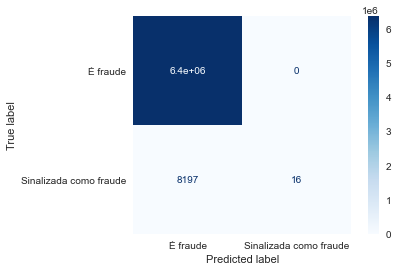

In [6]:
# Observando a matriz de confusão com os dados do dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, auc, roc_curve

cnf_matrix = confusion_matrix(df.ÉFraude, df.SinalizadaComoFraude)

disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['É fraude', 'Sinalizada como fraude'])
disp.plot(cmap = 'Blues')
plt.grid(False)

Observa-se que o dataset é muito desbalanceado. A quantidade de falsos negativos é alta e sendo este o tipo de erro mais grave, claramente o os dados da coluna SinalizadaComoFraude apresentam inconsistência

In [11]:
df.describe(percentiles = [.01, .05, .25, .5, .75, .95, .99], include = 'all')

,Passo,Tipo,Quantia,ClienteOrigem,SaldoInicialOrigem,SaldoFinalOrigem,ClienteDestino,SaldoInicialDestino,SaldoFinalDestino,ÉFraude,SinalizadaComoFraude
count,6362620.00000,6362620,6362620.00000,6362620,6362620.00000,6362620.00000,6362620,6362620.00000,6362620.00000,6362620.00000,6362620.00000
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,Saque,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,243.39725,NaN,179861.90355,NaN,833883.10407,855113.66858,NaN,1100701.66652,1224996.39820,0.00129,0.00000
std,142.33197,NaN,603858.23146,NaN,2888242.67304,2924048.50295,NaN,3399180.11299,3674128.94212,0.03590,0.00159
min,1.00000,NaN,0.00000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000
1%,9.00000,NaN,449.46760,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000
5%,16.00000,NaN,2224.09950,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000
25%,156.00000,NaN,13389.57000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000


In [6]:
df_fraude = df[df['ÉFraude'] == 1]
df_nao_fraude = df[df['ÉFraude'] == 0]

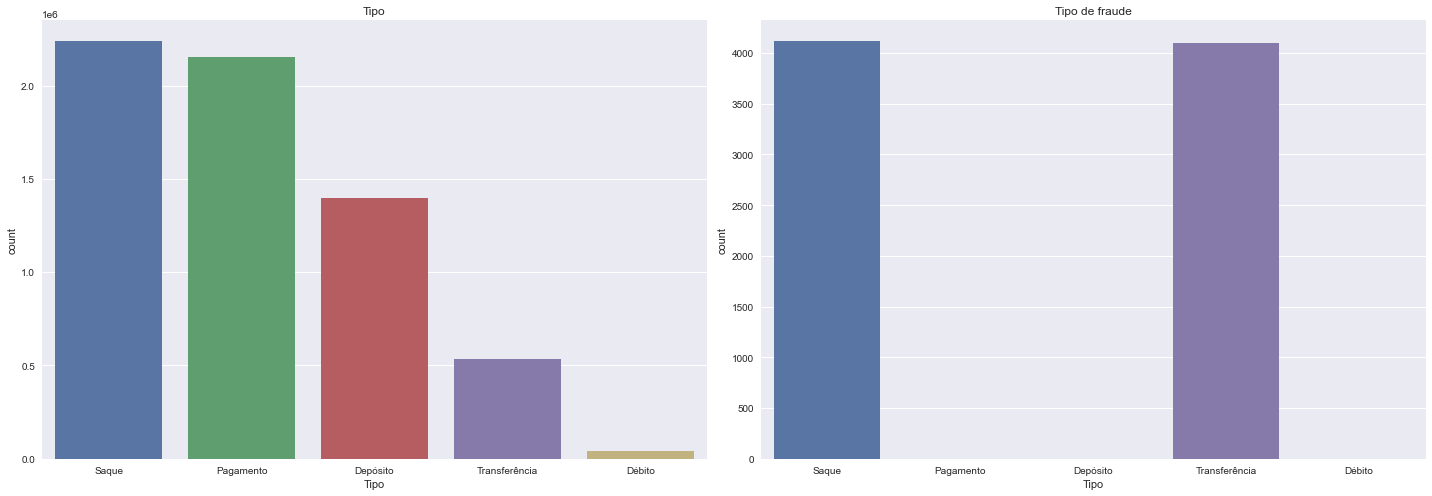

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7)) 

sns.countplot(data = df, ax=axes[0], x = 'Tipo', order = ['Saque', 'Pagamento', 'Depósito', 'Transferência', 'Débito'])
axes[0].set_title('Tipo')

sns.countplot(data = df_fraude, ax=axes[1], x='Tipo', order = ['Saque', 'Pagamento', 'Depósito', 'Transferência', 'Débito'])
axes[1].set_title('Tipo de fraude')

plt.tight_layout()
plt.show()

Percebe-se que as fraudes ocorreram por transferência e saque

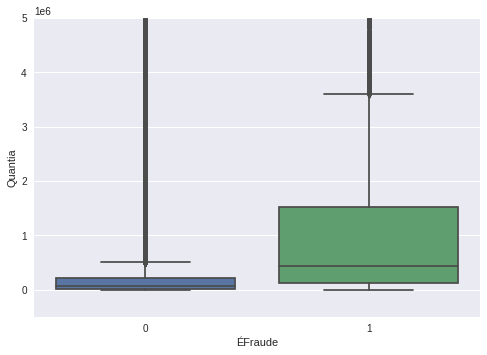

In [14]:
ax = sns.boxplot(data = df, x = 'ÉFraude', y = 'Quantia')
ax.set_ylim([-500000, 5000000])
plt.show()

Como esperado, as fraudes tem um valor mais alto que valores que não são fraude

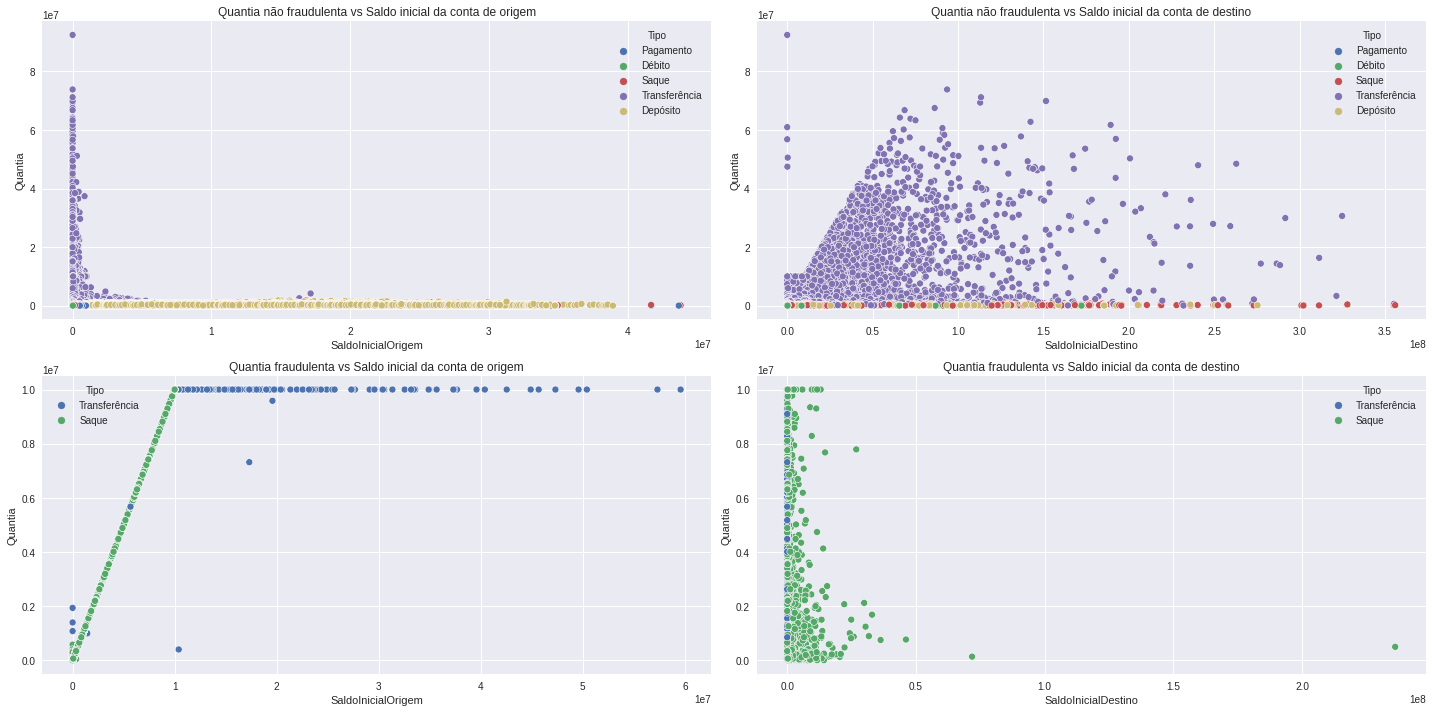

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10)) 

sns.scatterplot(data = df_nao_fraude, ax=axes[0][0], x = 'SaldoInicialOrigem', y = 'Quantia', hue = 'Tipo')
axes[0][0].set_title('Quantia não fraudulenta vs Saldo inicial da conta de origem')

sns.scatterplot(data = df_nao_fraude, ax=axes[0][1], x = 'SaldoInicialDestino', y = 'Quantia', hue = 'Tipo')
axes[0][1].set_title('Quantia não fraudulenta vs Saldo inicial da conta de destino')

sns.scatterplot(data = df_fraude, ax=axes[1][0], x = 'SaldoInicialOrigem', y = 'Quantia', hue = 'Tipo')
axes[1][0].set_title('Quantia fraudulenta vs Saldo inicial da conta de origem')

sns.scatterplot(data = df_fraude, ax=axes[1][1], x = 'SaldoInicialDestino', y = 'Quantia', hue = 'Tipo')
axes[1][1].set_title('Quantia fraudulenta vs Saldo inicial da conta de destino')

plt.tight_layout()
plt.show()

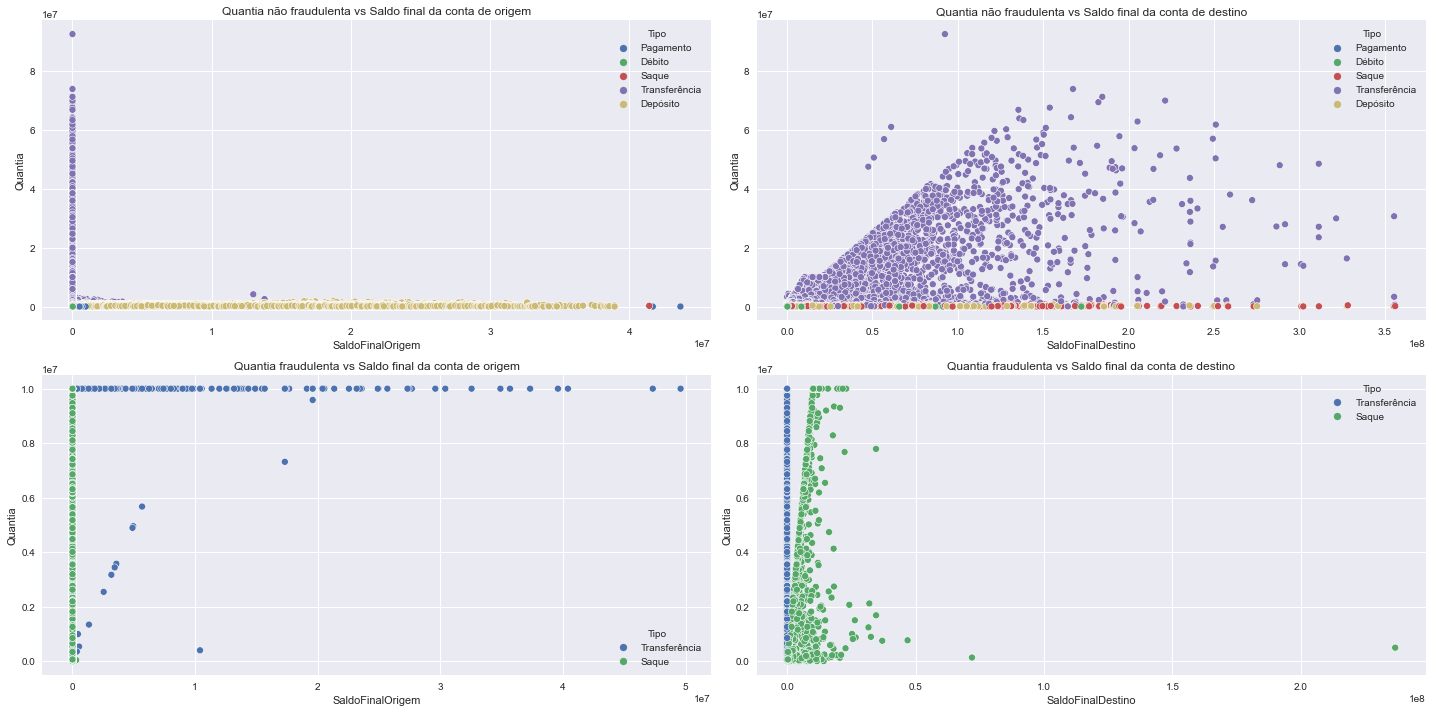

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10)) 

sns.scatterplot(data = df_nao_fraude, ax=axes[0][0], x = 'SaldoFinalOrigem', y = 'Quantia', hue = 'Tipo')
axes[0][0].set_title('Quantia não fraudulenta vs Saldo final da conta de origem')

sns.scatterplot(data = df_nao_fraude, ax=axes[0][1], x = 'SaldoFinalDestino', y = 'Quantia', hue = 'Tipo')
axes[0][1].set_title('Quantia não fraudulenta vs Saldo final da conta de destino')

sns.scatterplot(data = df_fraude, ax=axes[1][0], x = 'SaldoFinalOrigem', y = 'Quantia', hue = 'Tipo')
axes[1][0].set_title('Quantia fraudulenta vs Saldo final da conta de origem')

sns.scatterplot(data = df_fraude, ax=axes[1][1], x = 'SaldoFinalDestino', y = 'Quantia', hue = 'Tipo')
axes[1][1].set_title('Quantia fraudulenta vs Saldo final da conta de destino')

plt.tight_layout()
plt.show()

A variável SaldoInicialOrigem aparenta ter uma relação bem definida com valores fraudulentos, sendo 10.000.000, em geral, o valor transferido.

Em casos de fraude, contas de destino com maior saldo geralmente a fraude é através de saques, enquanto saldos menores geralmente recebem o valor via transferência.


In [5]:
# Criando variáveis de diferença de valores na origem e no destino

df['DiferencaOrigem'] = df['SaldoInicialOrigem'] - df['SaldoFinalOrigem']
df['DiferencaDestino'] = df['SaldoFinalDestino'] - df['SaldoInicialDestino']

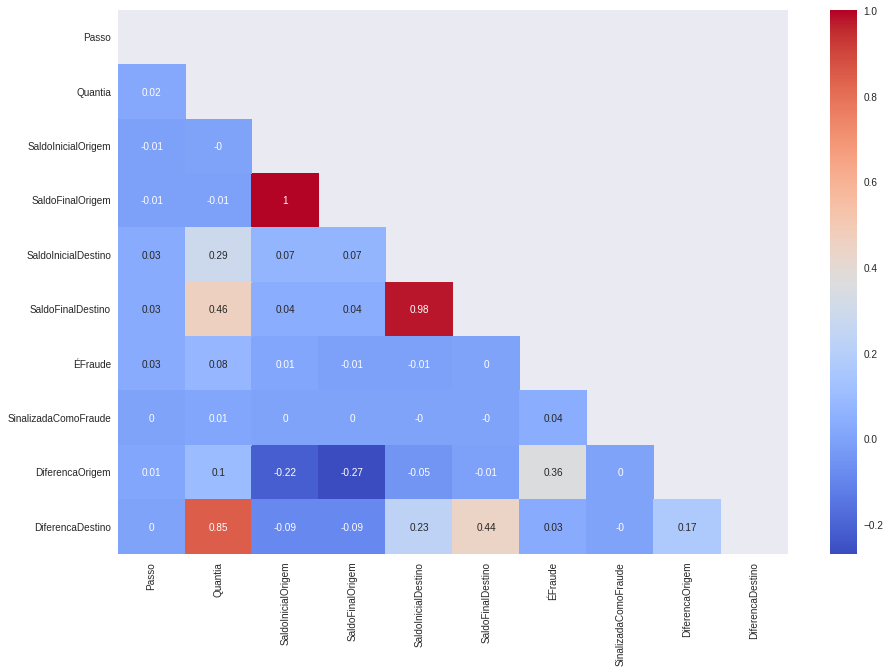

In [18]:
corr = df.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm')
plt.show()

As variáveis saldo inicial e final são muito correlacinadas, tanto para contas de origem quanto contas destino. Há também uma alta correlação entre a diferença de valor de destino e a quantia, o que é corroborado nos gráficos acima

In [6]:
# Como a variável Passo representa 1 hora, serão criadas novas features a partir dela, sendo estas o dia do mês e o horário da transação

df['Dia'] = (df['Passo']//24) + 1
df['Hora'] = (df['Passo']) - (df['Dia'] - 1)*24

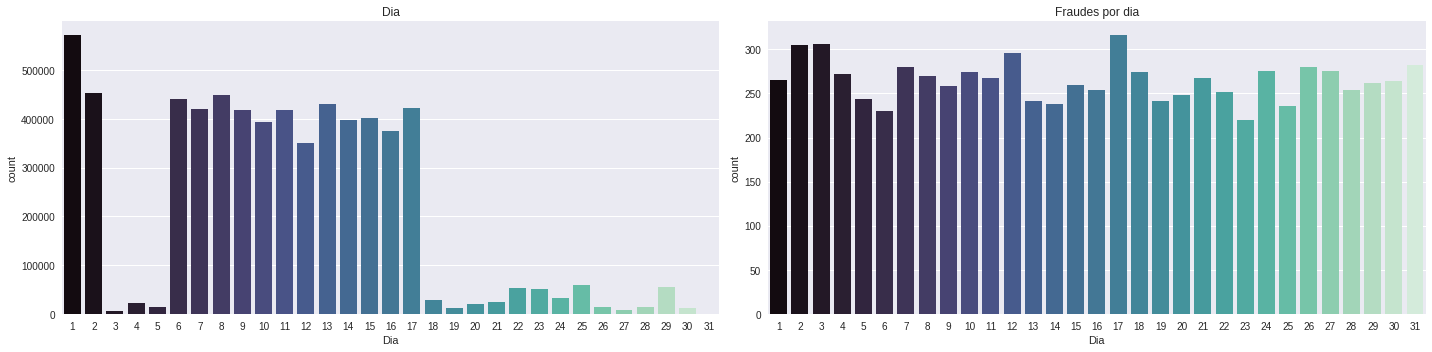

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5)) 

sns.countplot(data = df, ax = axes[0], x = 'Dia', palette = 'mako')
axes[0].set_title('Dia')

sns.countplot(data = df[df['ÉFraude'] == 1], ax = axes[1], x = 'Dia', palette = 'mako')
axes[1].set_title('Fraudes por dia')

plt.tight_layout()
plt.show()

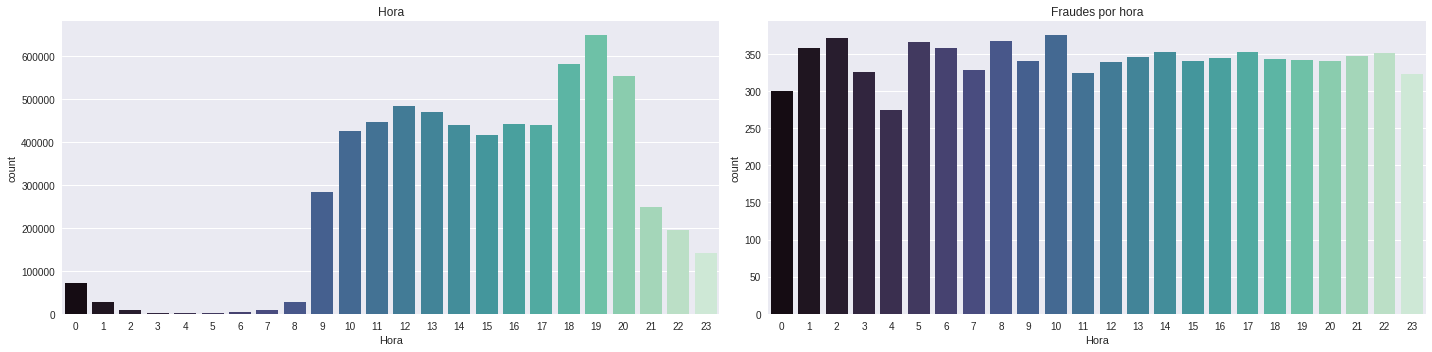

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5)) 

sns.countplot(data = df, ax = axes[0], x = 'Hora', palette = 'mako')
axes[0].set_title('Hora')

sns.countplot(data = df[df['ÉFraude'] == 1], ax = axes[1], x = 'Hora', palette = 'mako')
axes[1].set_title('Fraudes por hora')

plt.tight_layout()
plt.show()

Há uma concentração de transaçções os dois primeiros dias do mês e também entre o dia 6 e 17. Isto pode ser devido que estes são os dias em que geralmente são recebidos os salários e realizados os pagamentos das contas.

Há também mais transações entre as 9h e 20h, o que faz sentido com a realidade.

Já as fraudes não possuem um padrão. Há alguns picos de dias e horários que acontecem, porém não são tão significativos, ocorrendo majoritariamente de maneira distribuída.

Como estas variáveis se mostraram interessantes, serão utilizadas na modelagem ao invés do Passo e a variável SinalizadaComoFraude será excluída pois possui variáveis pouco significativas e com muitos falsos negativos.


In [7]:
df.drop(['Passo', 'SinalizadaComoFraude'], axis = 1, inplace = True)

## Modelagem

A fim de otimizar o tempo de modelagem, será utilizado uma amostra com 10% da base de dados

In [23]:
df_amostra = df.sample(n = 636262, random_state = 0)

Existem variáveis que são categóricas e para utilizá-las na modelagem, é necessário transformá-las:

In [24]:
cat_columns = []

for c in df_amostra.columns:
    if df_amostra[c].dtype == 'object': 
        cat_columns.append(c)

In [25]:
cat_columns

['Tipo', 'ClienteOrigem', 'ClienteDestino']

In [26]:
# Como a variável Tipo se mostrou significativa para sinalizar se é fraude ou não, será utilizado o get_dummies para ela

cat_columns.remove('Tipo')
cat_columns

['ClienteOrigem', 'ClienteDestino']

In [27]:
df_amostra = pd.get_dummies(df_amostra, columns = ['Tipo'], prefix = ['Tipo_'])

In [28]:
# Transformando as variáveis categóricas com o LabelEncoder

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_amostra['ClienteOrigem'] = encoder.fit_transform(df_amostra['ClienteOrigem'])
df_amostra['ClienteDestino'] = encoder.fit_transform(df_amostra['ClienteDestino'])

In [29]:
# Observando o dataset

df_amostra.head(2)

,Quantia,ClienteOrigem,SaldoInicialOrigem,SaldoFinalOrigem,ClienteDestino,SaldoInicialDestino,SaldoFinalDestino,ÉFraude,DiferencaOrigem,DiferencaDestino,Dia,Hora,Tipo__Depósito,Tipo__Débito,Tipo__Pagamento,Tipo__Saque,Tipo__Transferência
4644207,607193.64000,13820,15458649.28000,16065842.92000,128095,3394537.70000,2787344.06000,0,-607193.64000,-607193.64000,14,18,1,0,0,0,0
3800666,3473.75000,92994,0.00000,0.00000,358877,0.00000,0.00000,0,0.00000,0.00000,12,17,0,0,1,0,0


In [30]:
X = df_amostra.copy()
X.drop(columns = 'ÉFraude', inplace = True)

y = df_amostra['ÉFraude']

Removendo as variáveis que são altamente correlacionadas entre si para não enviesar o modelo

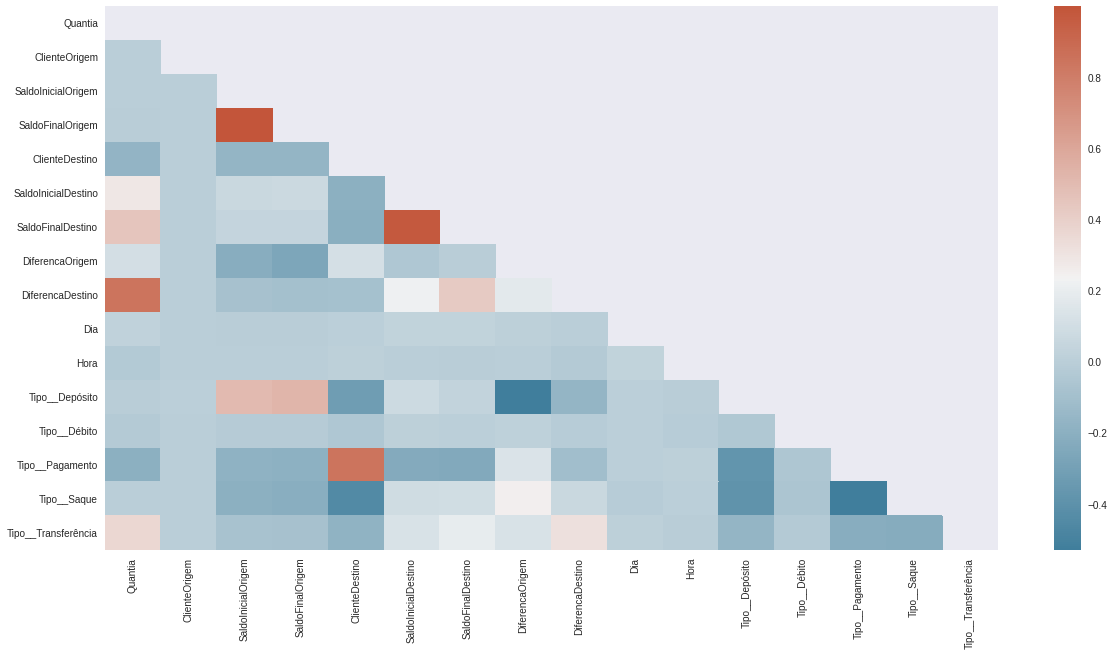

In [31]:
corr_matrix = X.corr()
f, ax = plt.subplots(figsize=(20, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, annot=False, mask = mask, cmap=cmap);

In [32]:
correlated_features = set()
for i in range(len(corr_matrix .columns)):
    for j in range(i+1, len(corr_matrix .columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            print(corr_matrix.columns[i]+" - "+corr_matrix.columns[j])
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

print(correlated_features)

Quantia - DiferencaDestino
SaldoInicialOrigem - SaldoFinalOrigem
ClienteDestino - Tipo__Pagamento
SaldoInicialDestino - SaldoFinalDestino
{'SaldoInicialDestino', 'SaldoInicialOrigem', 'Quantia', 'ClienteDestino'}


In [33]:
X_novo = X.drop(labels = correlated_features, axis = 1)

In [34]:
# Observando o target

y.value_counts()

0    635436
1       826
Name: ÉFraude, dtype: int64

Como visto antes, há poucos dados de fraude. Portanto, será utilizado do oversampling a fim de balancear os dados

In [35]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Separando em treino e teste 

X_train, X_test, y_train, y_test = train_test_split(X_novo, y , test_size = .2, random_state = 42)

In [36]:
data = pd.concat([X_train, y_train], axis = 1)

nao_fraude = data[data.ÉFraude == 0]
fraude = data[data.ÉFraude == 1]

# Upsampled da minoria
fraude_upsampled = resample(fraude, replace = True, n_samples = len(nao_fraude), random_state = 13)

# Combinando a maioria com a upsampled minoria
upsampled = pd.concat([nao_fraude, fraude_upsampled])

# Checando
upsampled.ÉFraude.value_counts()

0    508353
1    508353
Name: ÉFraude, dtype: int64

In [37]:
# Separando as features do target

X_train = upsampled.drop('ÉFraude', axis = 1)
y_train = upsampled['ÉFraude']

In [38]:
X_train.shape, X_test.shape

((1016706, 12), (127253, 12))

In [40]:
# Importando o StandardScaler para normalizar os dados

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_amostra = pd.DataFrame(scaler.fit_transform(df_amostra), columns = df_amostra.columns)

## Treinando o modelo

Foram escolhidos 3 modelos a fim de observar sua performances, sendo eles:

- Decision Tree
- XGBoost
- Random Forest

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [42]:
rfc = RandomForestClassifier(random_state = 42)
dtc = DecisionTreeClassifier(random_state = 42)
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 42)

#### **Treino com Decision Tree**

In [83]:
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

pd.DataFrame(data=[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)],
                   index=["Acurácia", "Recall", "F1", "ROC-AUC Score"])

,0
Acurácia,0.99949
Recall,0.71176
F1,0.78827
ROC-AUC Score,0.85582


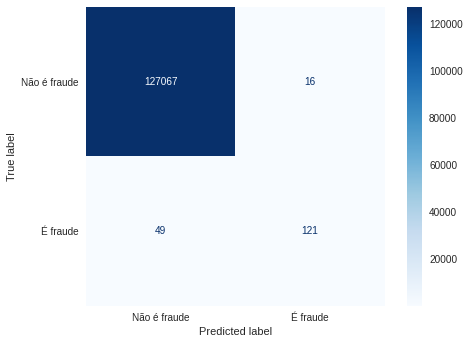

In [84]:
cnf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Não é fraude', 'É fraude'])
disp.plot(cmap = 'Blues')
plt.grid(False)

#### **Treino com XGBoost**

In [85]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

pd.DataFrame(data=[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)],
                   index=["Acurácia", "Recall", "F1", "ROC-AUC Score"])

,0
Acurácia,0.98935
Recall,0.98235
F1,0.19775
ROC-AUC Score,0.98586


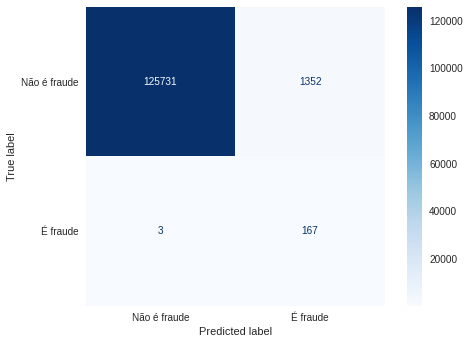

In [86]:
cnf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Não é fraude', 'É fraude'])
disp.plot(cmap = 'Blues')
plt.grid(False)

#### **Treino com Random Forest**

In [73]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

pd.DataFrame(data=[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)],
                   index=["Acurácia", "Recall", "F1", "ROC-AUC Score"])

,0
Acurácia,0.99961
Recall,0.75882
F1,0.84039
ROC-AUC Score,0.87938


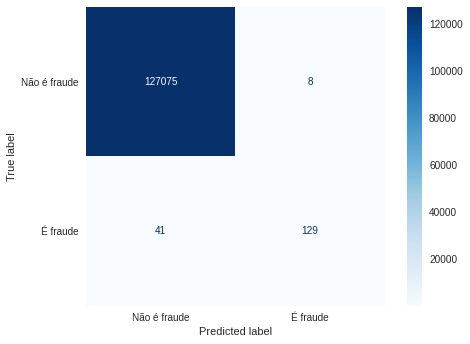

In [74]:
cnf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Não é fraude', 'É fraude'])
disp.plot(cmap = 'Blues')
plt.grid(False)

## Análise da solução e conclusão

Como foi possível observar, os valores de F1 nos algoritmos de Decision Tree e XGBoost foram muito abaixo do resultado obtido com o Random Forest.

Algo interessante de se notar é que mesmo o XGBoost tendo um F1 baixo, o seu valor de falsos negativos foi o menor dos três algoritmos. Este tipo de erro é o mais grave de se cometer, entretando, o número de falsos positivos foi alto, o que acarretou em um baixo F1. Este algoritmo poderia ser escolhido já que o erro grave teve um melhor resultado, entretando, pelo alto número de FP, poderia causar um aumento no número de churns, acarretando em prejuízos para a empresa. Para uma decisão final sobre o impacto deste resultado, seria necessário uma discussão com o time de negócios.

O melhor modelo seria aquele que melhor atende aos objetivos da empresa, sendo essencial observar com outros membros da instituição o peso de cada resultado a fim de se maximar a performance de acordo com a necessidade, podendo ser a com o maior AUC, a com o maior número de detecção de fraudes ou mesmo com menor número de falsos positivos.

Algumas variáveis que não estavam presentes poderiam melhorar o resultado, como a renda do responsável pela conta e dados históricos além de 1 mês. Como os dados fornecidos compreendem valores de apenas 1 mês, não há um extenso histórico sobre as transações, podendo impulsionar a performance dos modelos se estivessem presentes.